# Image Segmentation with UNet


#
Binary Segmentation


## Connect and Unzip data from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip /content/drive/MyDrive/unets/Archive.zip

Archive:  /content/drive/MyDrive/unets/Archive.zip
replace train/EO_801.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data preprocessing

In [2]:
# importing libraries
import os
import cv2
import glob
import random
import pandas as pd
import zipfile

import numpy as np
from PIL import Image

from keras.optimizers import Adam

from matplotlib import pyplot as plt
from tensorflow.keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Dropout

In [3]:
# Define paths for masks and images
image_directory = "/content/train"
mask_directory = "/content/label"
test_directory = "/content/Test"

SIZE = 256

In [4]:
# Loading train and test images and masks
image_data = []
mask_data = []
filenames_masks = []
filenames_train = []
test_data = []
filenames_testset = []
images = os.listdir(image_directory)
masks = os.listdir(mask_directory)
Tests = os.listdir(test_directory)

# Load train images in grayscale
for image_name in images:
    if image_name.endswith(".jpg"):
        path = os.path.join(image_directory, image_name)

        image = cv2.imread(path, 0)
        image = Image.fromarray(image).resize((SIZE, SIZE))
        image_data.append(np.array(image))
        filenames_train.append(image_name)

# Load test images in grayscale
for image_name in Tests:
    if image_name.endswith(".jpg"):
        path = os.path.join(test_directory, image_name)
        image = cv2.imread(path, 0)
        image = Image.fromarray(image).resize((SIZE, SIZE))
        test_data.append(np.array(image))
        filenames_testset.append(image_name)

# Load mask images in grayscale
for image_name in masks:
    if image_name.endswith(".jpg"):
        path = os.path.join(mask_directory, image_name)
        image = cv2.imread(path, 0)
        image = Image.fromarray(image).resize((SIZE, SIZE))
        mask_data.append(np.array(image))
        filenames_masks.append(image_name)


In [5]:
# Normalize images and masks
image_data = np.expand_dims(normalize(np.array(image_data), axis=1), 3)
mask_data = np.expand_dims(np.array(mask_data), 3) / 255.0
test_data = np.expand_dims(normalize(np.array(test_data), axis=1), 3)

# Split data into training and validation sets
X_train, X_val, y_train, y_val, train_filenames, val_filenames = train_test_split(
    image_data, mask_data, filenames_train, test_size=0.10, random_state=0
)

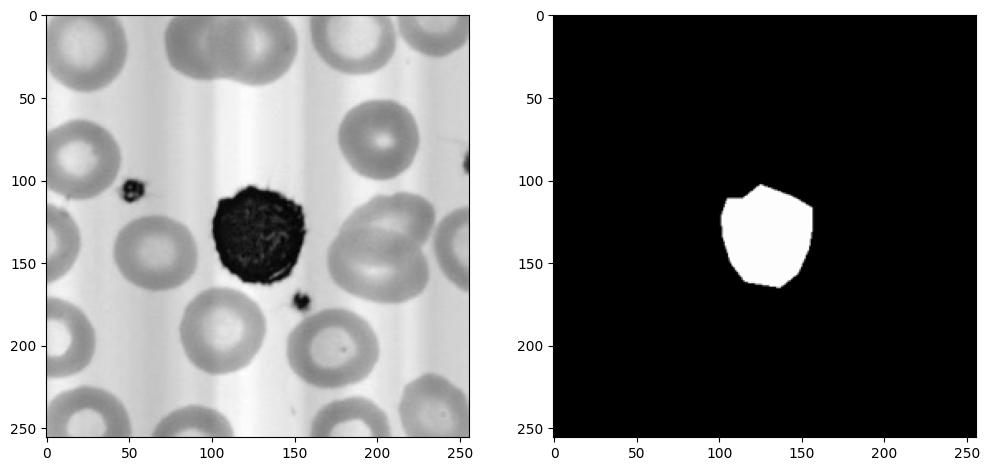

In [7]:
# Visualize training image and mask
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (SIZE, SIZE)), cmap="gray")
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (SIZE, SIZE)), cmap="gray")
plt.show()

# Building of Unet model for segmentation


In [10]:
# convolution block
def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

#encoder block
def encoder_block(inputs, num_filters):
  x = conv_block(inputs, num_filters)
  p = MaxPool2D((2,2))(x)

  return x, p

#decoder block
def decoder_block(inputs, skip, num_filters):
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(inputs)
  x = Concatenate()([x, skip])
  x = conv_block(x, num_filters)
  return x

# unet
def build_unet(input_shape):
  inputs = Input(input_shape)

  # Encoder
  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  # Bridge
  b1 = conv_block(p4, 1024)

  # Decoder
  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  outputs = Conv2D(1, 1, padding = "same", activation = "sigmoid")(d4)

  model = Model(inputs, outputs, name="UNET")
  return model

In [14]:
input_shape = (256,256,1)
model = build_unet(input_shape)

In [18]:

model.compile(optimizer = Adam(learning_rate=1e-3), loss="binary_crossentropy",
              metrics = ["accuracy"])

In [17]:
history = model.fit(X_train,
                    y_train,
                    batch_size=16,
                    verbose = 1,
                    epochs = 100,
                    validation_data=(X_val, y_val),
                    shuffle=False)

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
# Visualize loss and accuracy
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(epochs, loss, "y", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, "y", label="Training ACC")
plt.plot(epochs, val_acc, "r", label="Validation ACC")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [6]:
# just run this if you do not want to train the model from scrach.

from keras.models import load_model
model_path = "/content/drive/MyDrive/unet/model_350_signle.hdf5"
model = load_model(model_path)


In [7]:
# Predict the masks for all validation images
y_pred = model.predict(X_val)

# Apply threshold to get binary masks
threshold = 0.5
y_pred_thresholded = (y_pred > threshold).astype(np.uint8)


2/2 [==============================] - 27s 4s/step


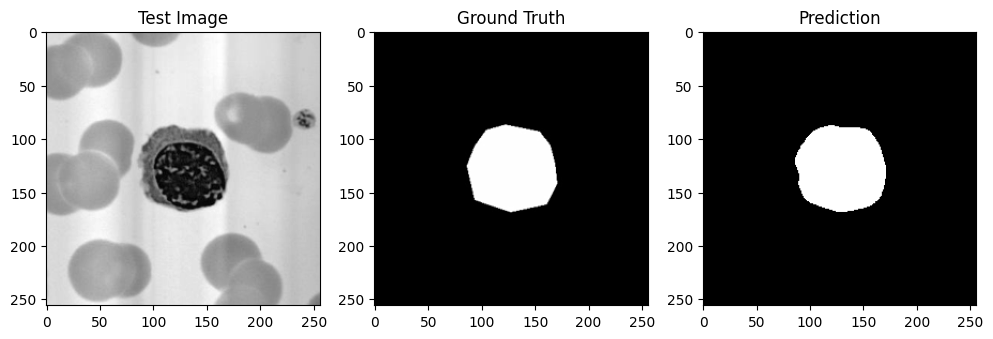

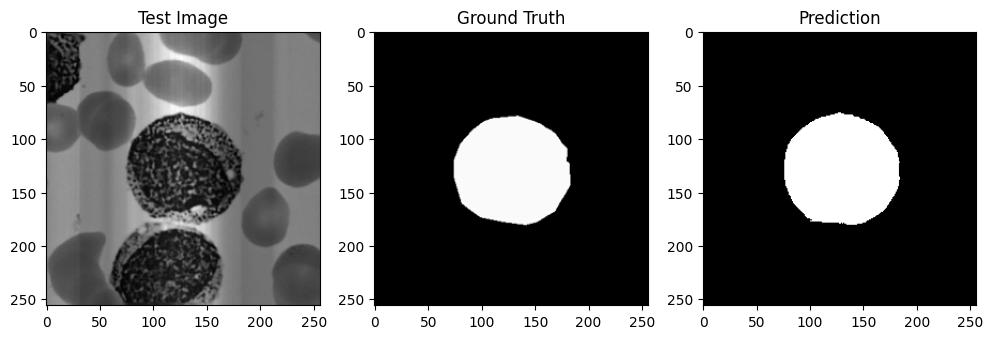

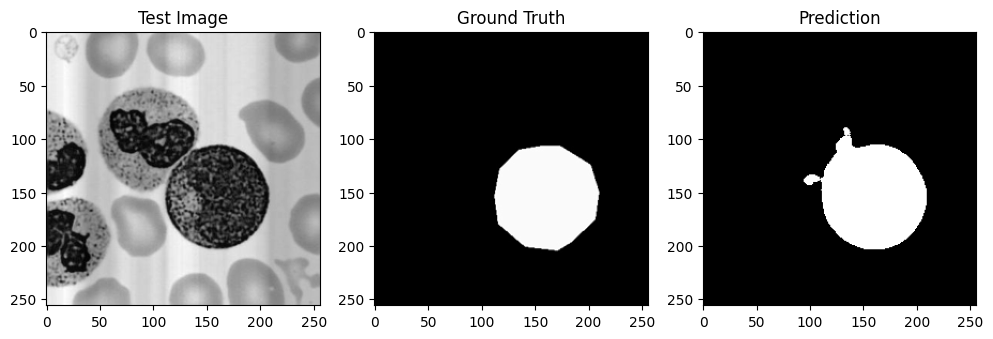

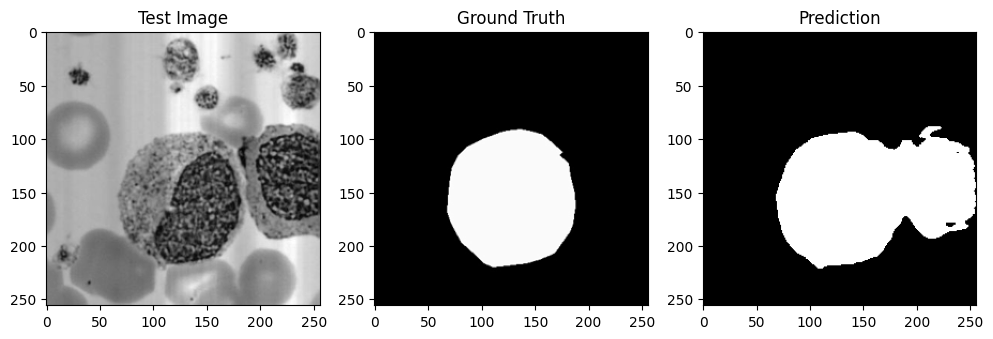

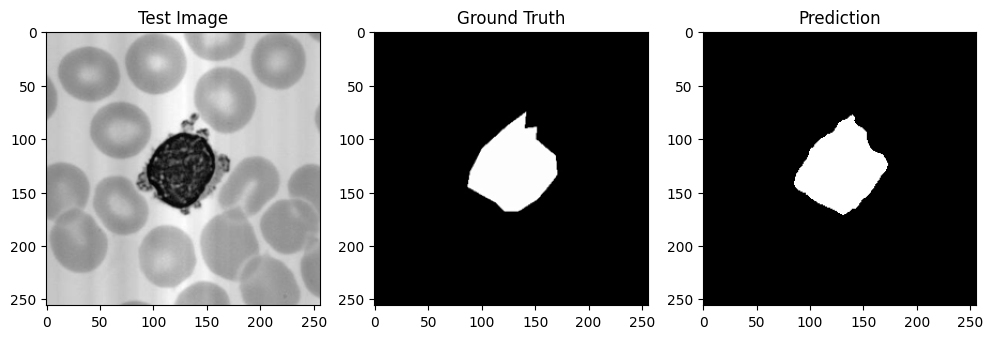

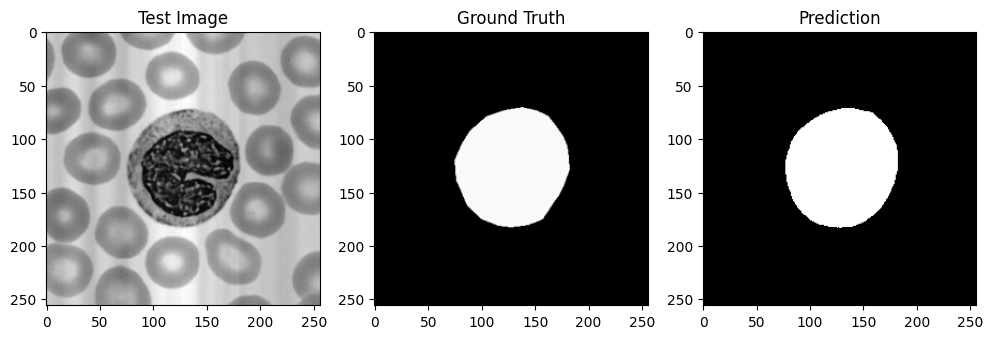

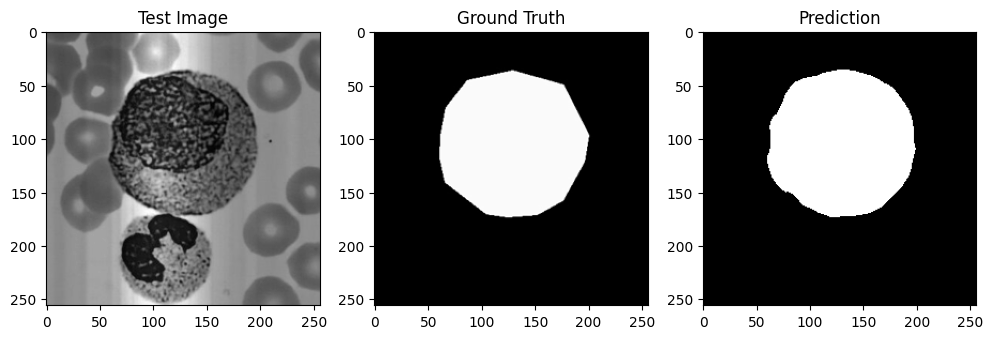

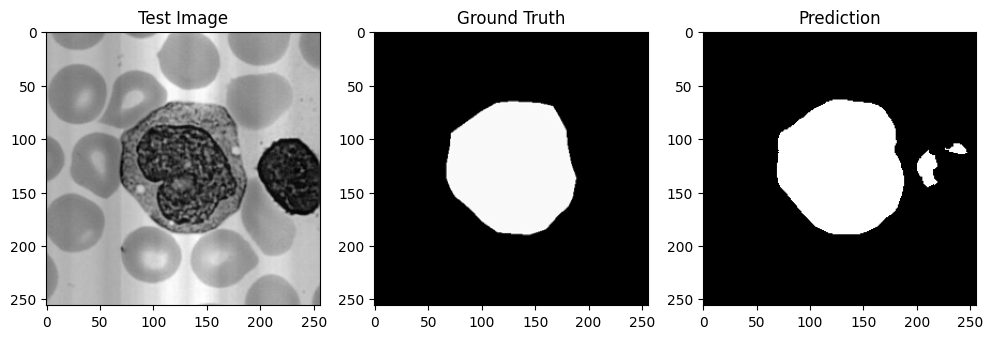

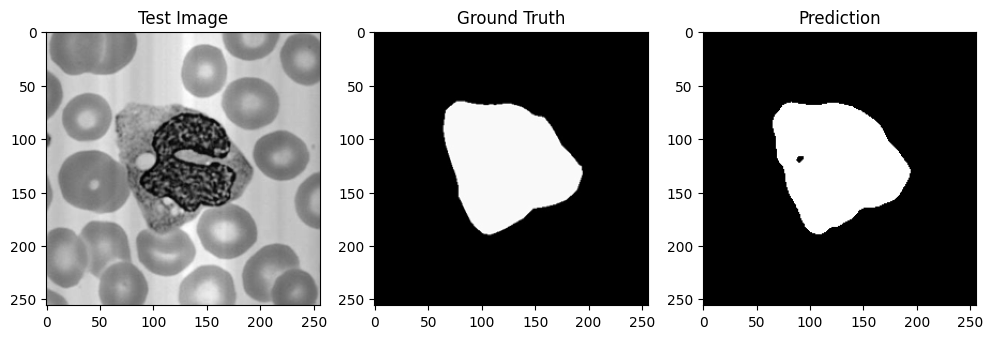

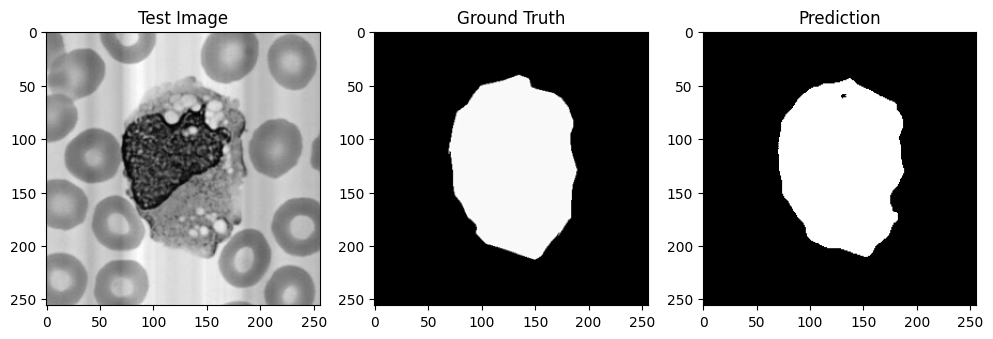

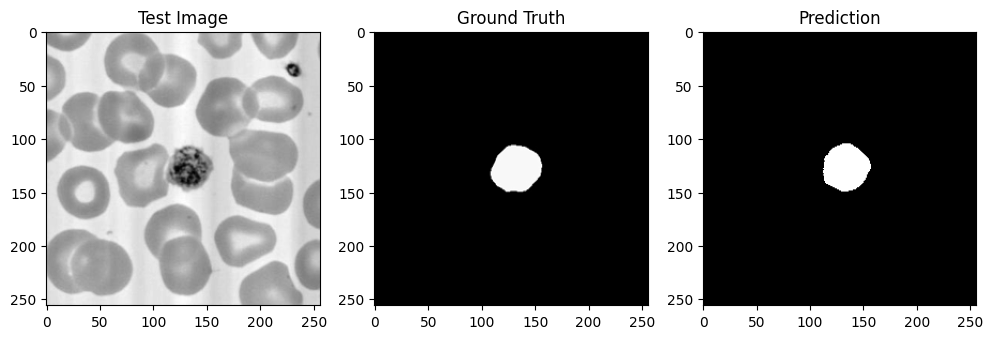

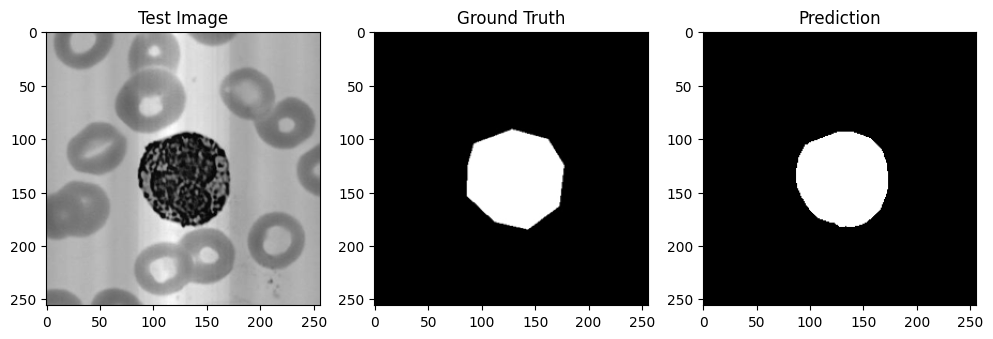

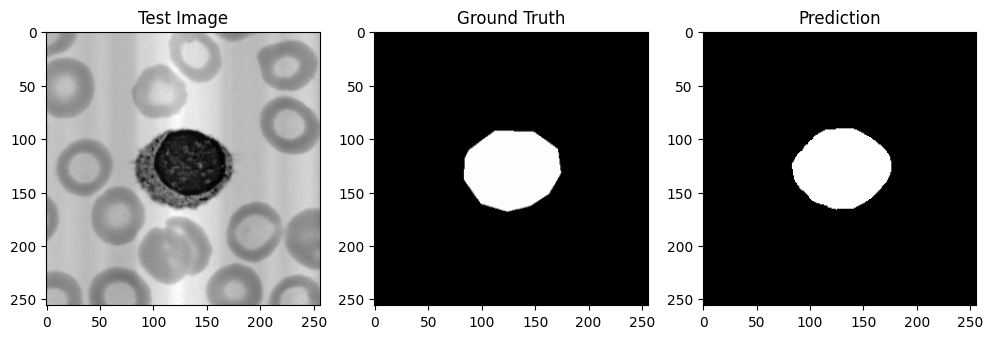

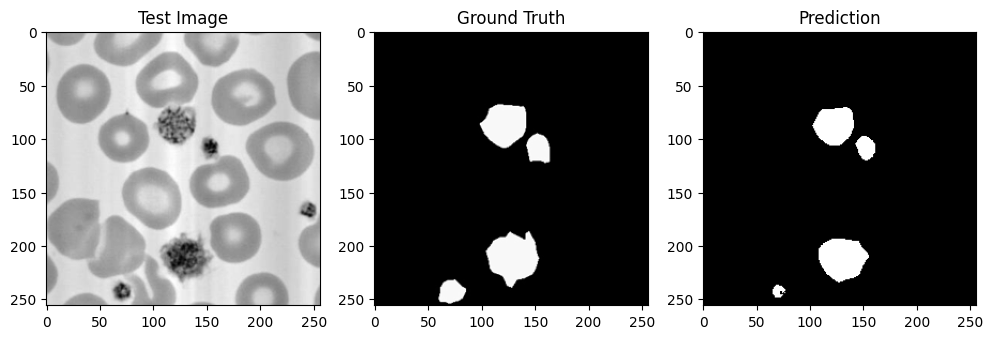

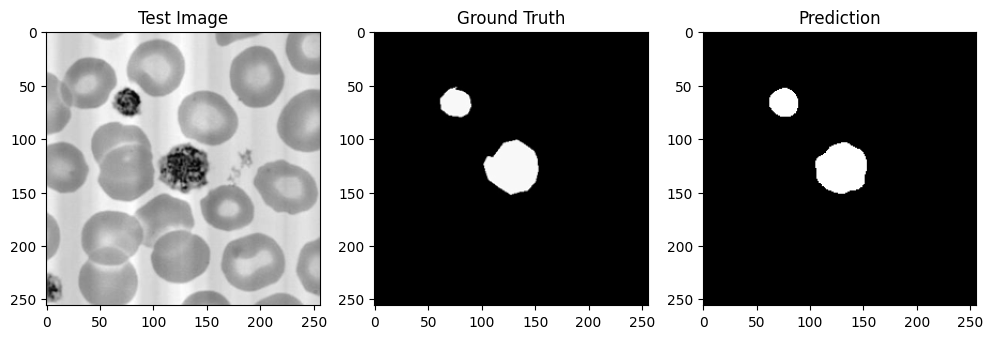

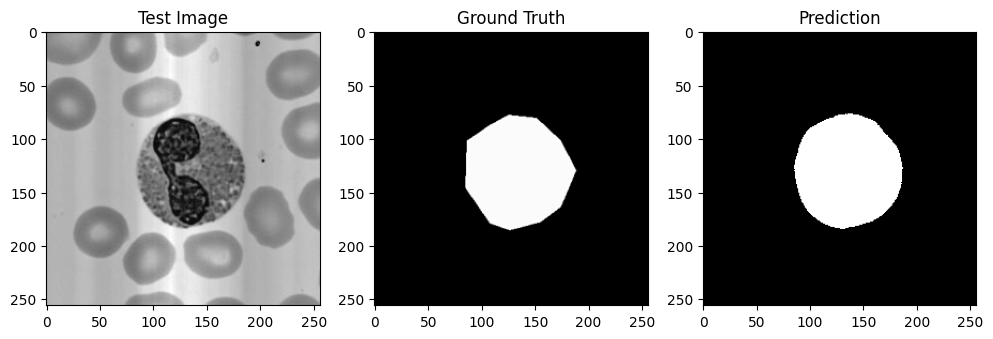

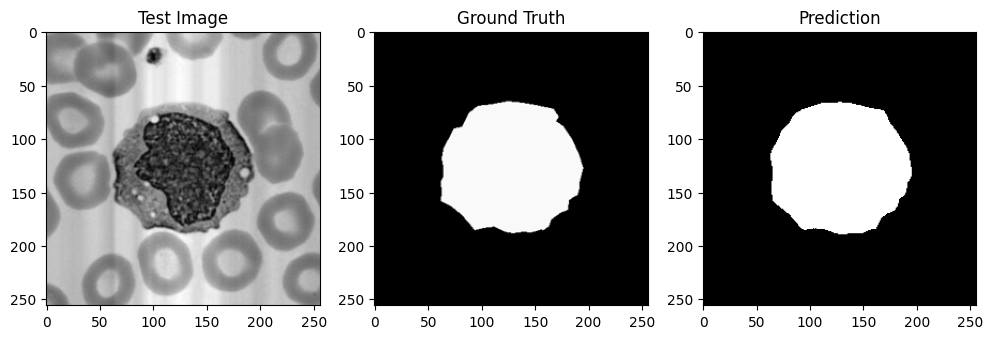

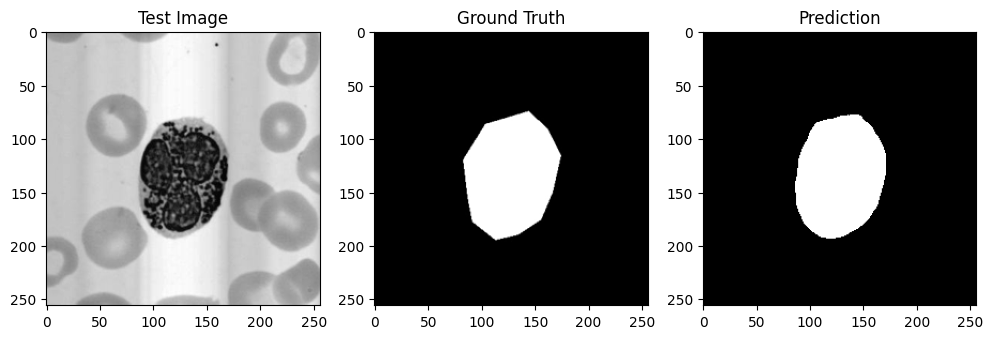

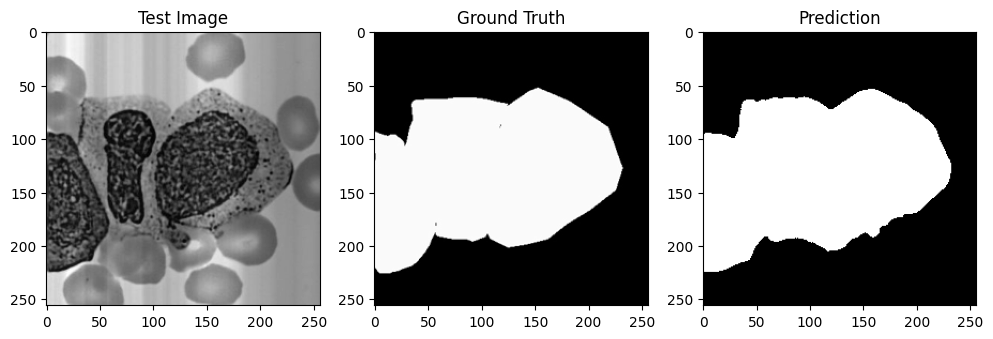

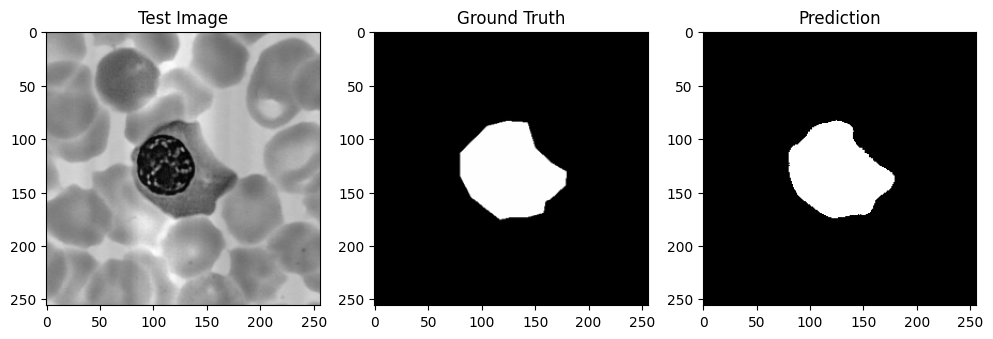

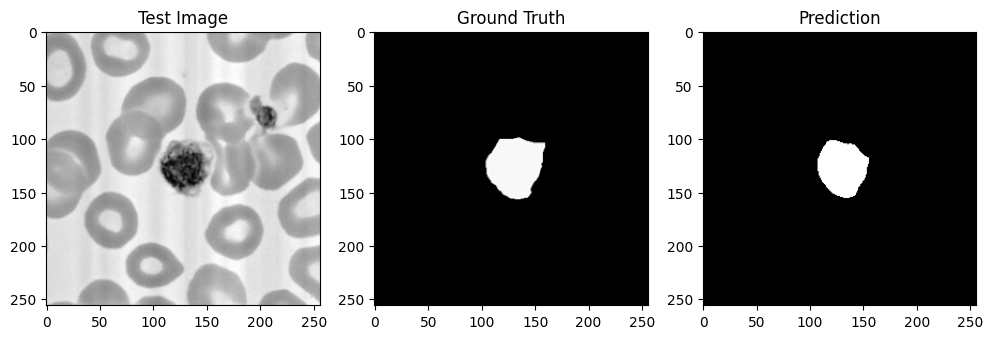

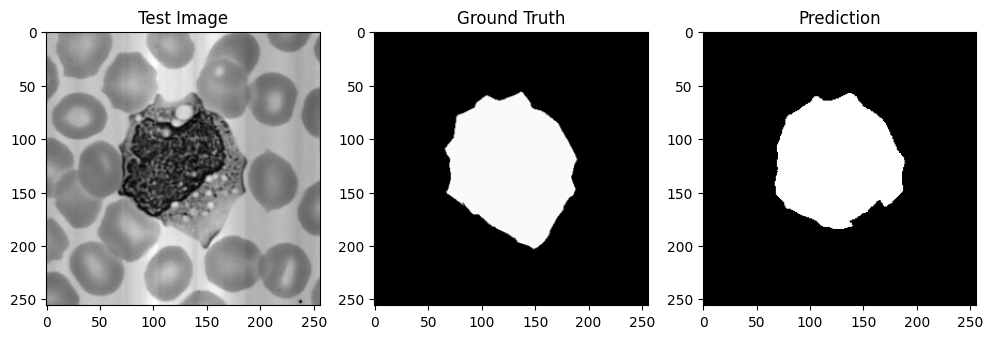

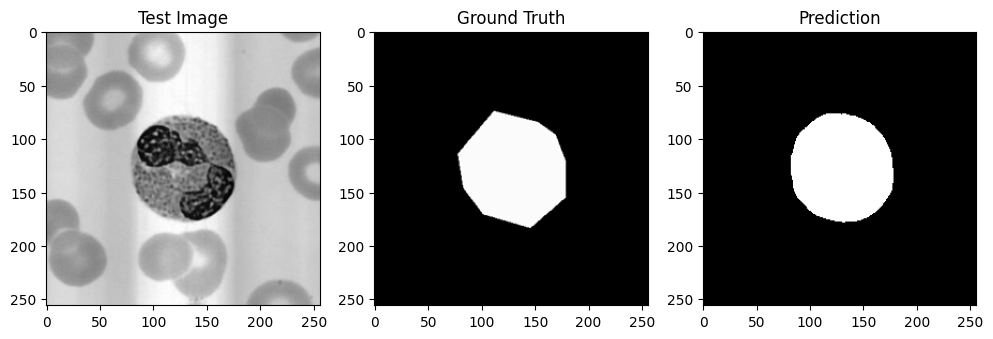

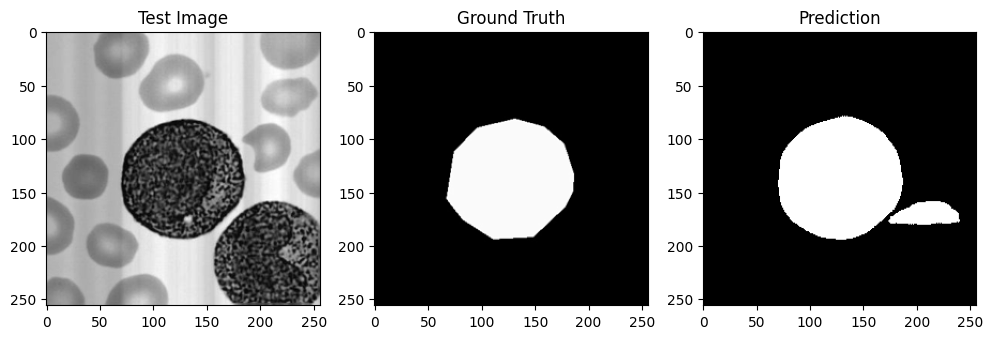

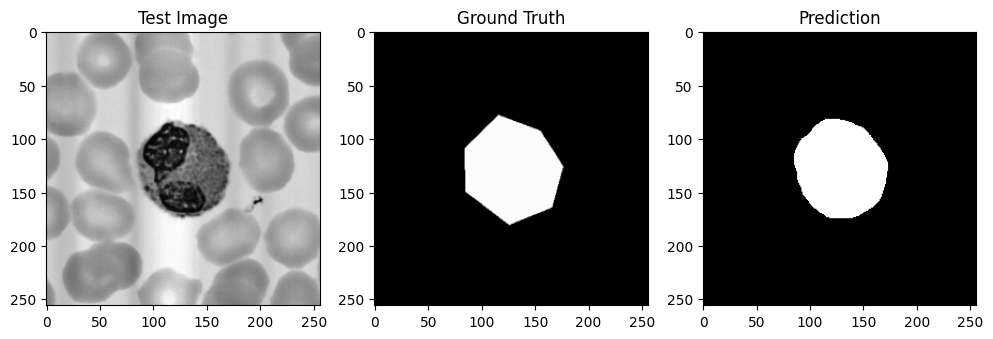

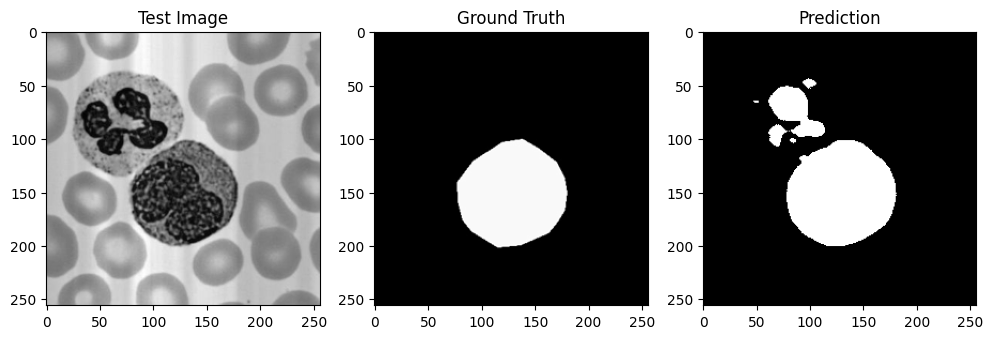

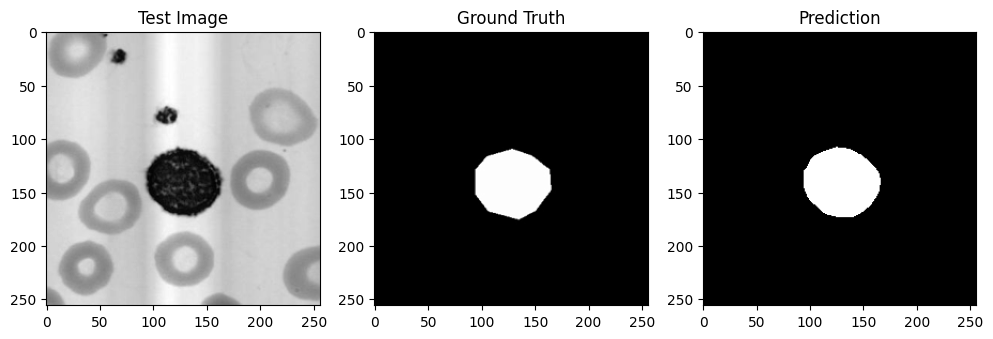

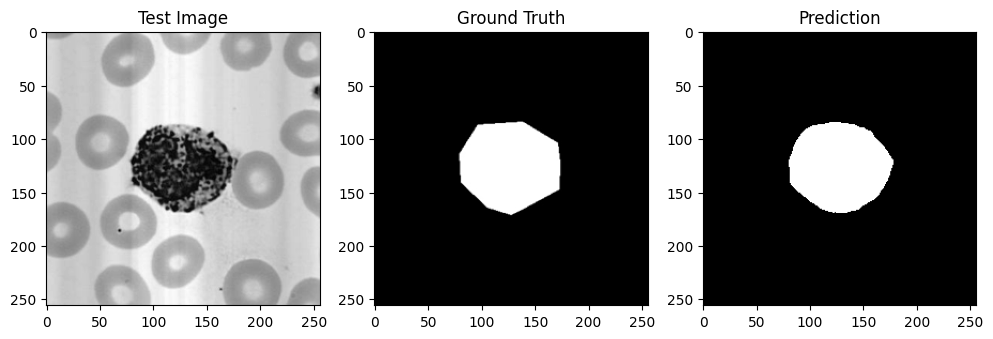

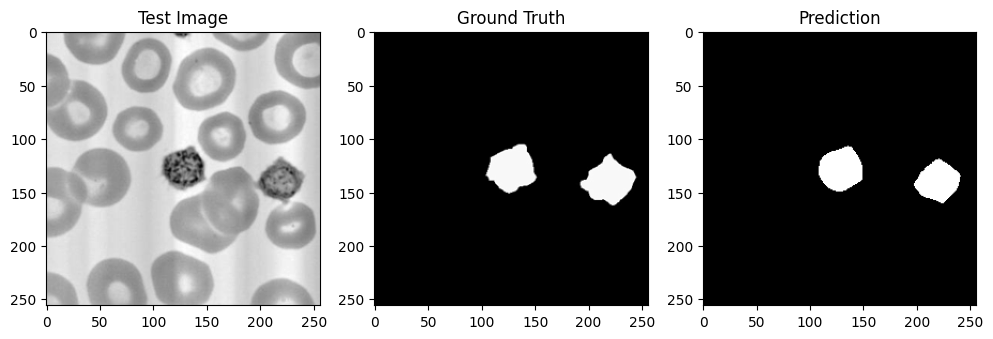

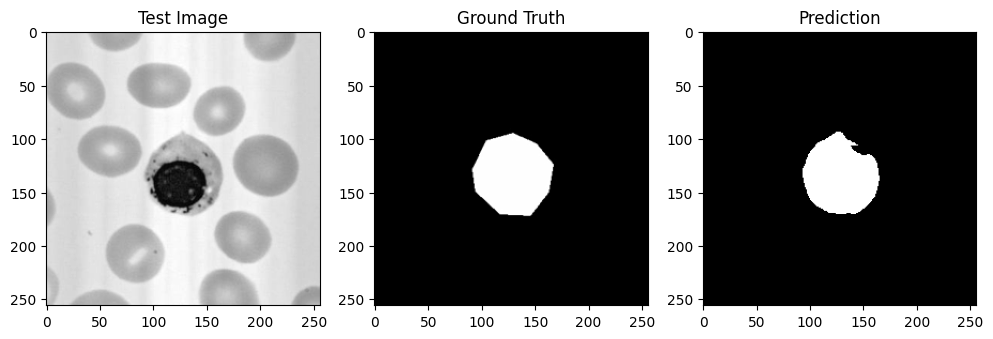

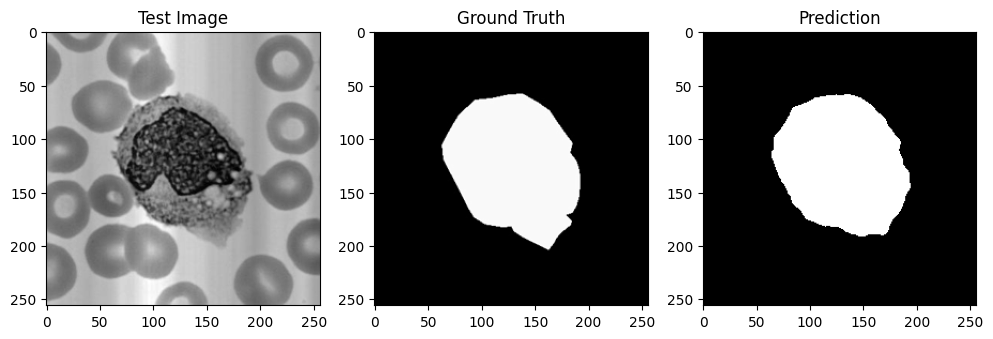

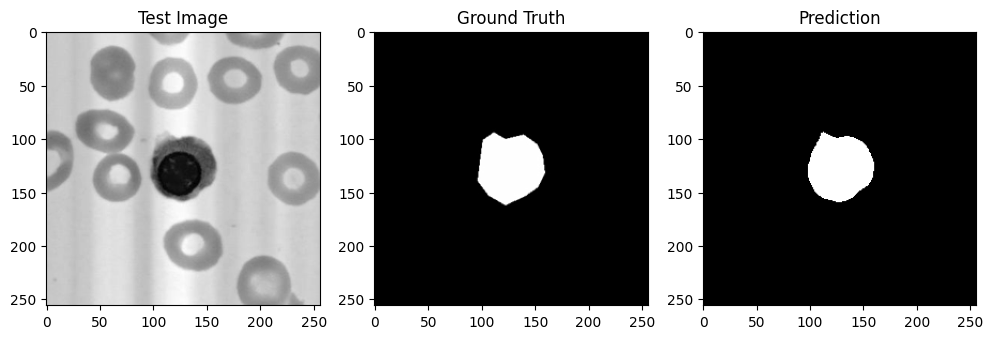

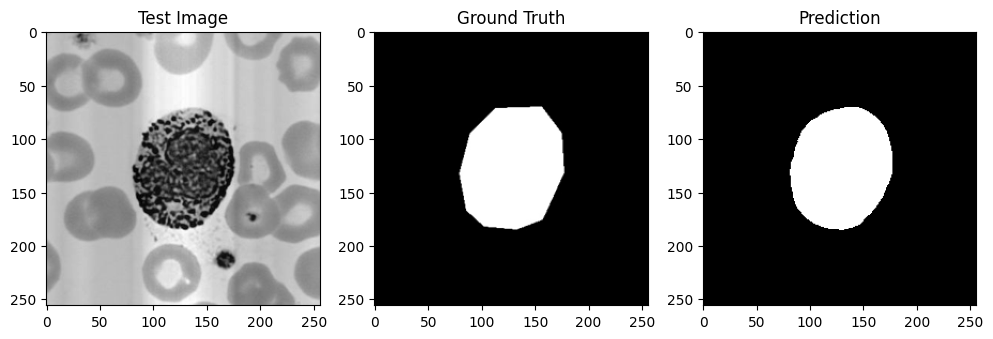

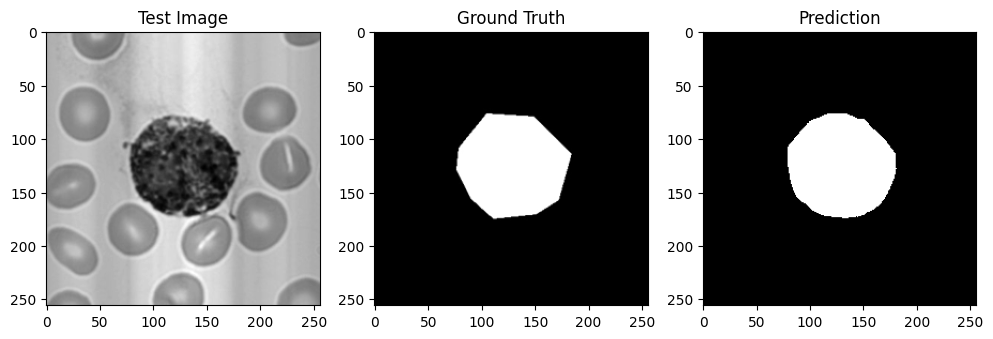

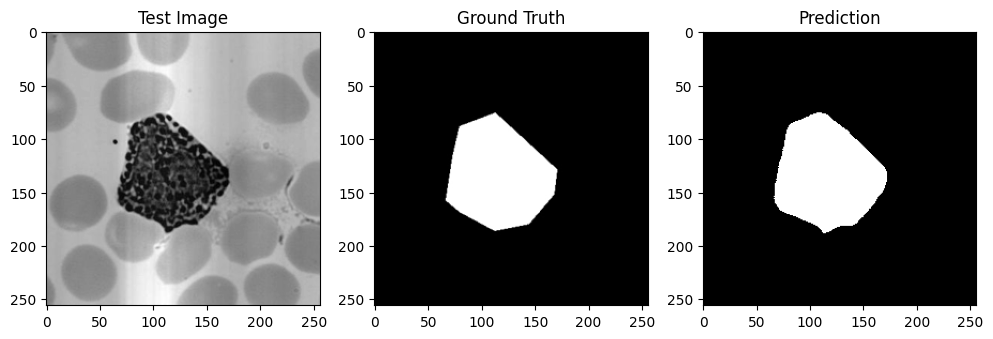

All predicted masks have been saved and visualized.


In [8]:
# Here we make predictory masks
predicted_mask_dir = '/content/drive/MyDrive/unet/pred_label'
os.makedirs(predicted_mask_dir, exist_ok=True)

# Save the predicted masks and visualize
for i in range(len(X_val)):
    test_img = X_val[i]
    ground_truth = np.reshape(y_val[i], (SIZE,SIZE))

    prediction = y_pred_thresholded[i]

    # Save prediction with the same name as the original image
    original_filename = f"pred_mask_{i}.png"
    pred_filename = os.path.join(predicted_mask_dir, original_filename)
    cv2.imwrite(pred_filename, prediction * 255)  # Multiply by 255 to convert to 8-bit image

    # Visualize the test image, ground truth mask, and prediction
    plt.figure(figsize=(12, 6))

    plt.subplot(131)
    plt.title("Test Image")
    plt.imshow(test_img.squeeze(), cmap="gray")

    plt.subplot(132)
    plt.title("Ground Truth")
    plt.imshow(ground_truth, cmap="gray")

    plt.subplot(133)
    plt.title("Prediction")
    plt.imshow(prediction.squeeze(), cmap="gray")

    #plt.savefig(os.path.join(predicted_mask_dir, f"comparison_{i}.png"))
    plt.show()
    plt.close()


print("All predicted masks have been saved and visualized.")

## produce mask for all  test set

In [9]:
# produce masks for text data - all
y_pred_test = model.predict(test_data)
test_img = test_data
# Apply threshold to get binary masks
threshold = 0.5
y_pred_thresholded = (y_pred_test > threshold).astype(np.uint8)
# Directory to save the predicted masks

522/522 [==============================] - 184s 353ms/step


### here we remove the small artifacts if their size is smaller than 90% of the biggest contour (biggest segmented part)

In [11]:
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
# Define the directory to save the filtered masks
filtered_mask_dir = '/content/drive/MyDrive/unet/filtered_masks_test'
filtered_mask_dir_valuation = '/content/drive/MyDrive/unet/filtered_masks_test_filtered_mask_dir_valuation'

bad_image_dir = '/content/drive/MyDrive/unet/bad_images'
os.makedirs(filtered_mask_dir, exist_ok=True)
os.makedirs(bad_image_dir, exist_ok=True)
os.makedirs(filtered_mask_dir_valuation, exist_ok=True)
# Function to keep the largest white area in the mask
def keep_largest_area(mask, threshold_ratio=1):
    # Label connected regions
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)

    if len(regions) == 0:
        return mask  # Return the original mask if no regions found

    # Get the largest region
    largest_region = max(regions, key=lambda r: r.area)
    largest_area = largest_region.area

    # Filter out small regions
    filtered_mask = np.zeros_like(mask)
    for region in regions:
        if region.area >= largest_area * threshold_ratio:
            for coord in region.coords:
                filtered_mask[coord[0], coord[1]] = 1

    return filtered_mask


In [10]:
filenames_testset[5477]

'ERB_59475.jpg'

In [12]:
# Save the filtered masks and visualize
for i in range(5477,len(test_img)):

    test_img_data = test_img[i].squeeze()
    prediction = y_pred_thresholded[i].squeeze()

    # Keep only the largest white area
    filtered_prediction = keep_largest_area(prediction)

    # Count the number of regions
    labeled_mask = label(filtered_prediction)
    regions = regionprops(labeled_mask)

    if len(regions) > 1:
        save_dir = bad_image_dir
    else:
        save_dir = filtered_mask_dir

    # Save the filtered prediction
    original_filename = filenames_testset[i]
    pred_filename = pred_filename = os.path.join(save_dir, original_filename)
    cv2.imwrite(pred_filename, filtered_prediction * 255)  # Multiply by 255 to convert to 8-bit image

    # Visualize the test image, ground truth mask, and filtered prediction
    #plt.figure(figsize=(12, 6))

    #plt.subplot(121)
    #plt.title(original_filename)
    #plt.imshow(test_img_data, cmap="gray")

    #plt.subplot(122)
    #plt.title("Filtered Prediction")
    #plt.imshow(filtered_prediction, cmap="gray")
    #plt.savefig(os.path.join(filtered_mask_dir_valuation, original_filename) )
    #plt.close()

print("All filtered masks have been saved and visualized.")

All filtered masks have been saved and visualized.


# second data cleaning *italicized text*

In [31]:
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
'''
here we load the binary mask that we produced for all the test sets. we divide them to subcategories using their name and also mapping.
'''

# Define class mapping based on filename prefixes
cell_type_mapping = {
    'BA': 0,
    'ERB': 1,
    'LY': 2,
    'SNE': 3,
    'EO': 4,
    'PMY': 5,
    'MO': 6,
    'PLATELET': 7,
    'MY': 5  # Map 'MY' to the same label as 'PMY'
}

# Base path where images are stored
base_path = '/content/drive/MyDrive/unet/filtered_masks_test'

# Initialize data structure to store results
data = []

# Helper function to extract white area from binary mask
def get_white_area(binary_image_path):
    image = cv2.imread(binary_image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    white_area = cv2.countNonZero(image)
    return white_area

# Iterate over each image and categorize them
for filename in os.listdir(base_path):
    file_path = os.path.join(base_path, filename)
    if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        prefix = filename.split('_')[0]
        if prefix in cell_type_mapping:
            label = cell_type_mapping[prefix]
            white_area = get_white_area(file_path)
            if white_area is not None:
                data.append({
                    'Label': label,
                    'Mask_Path': file_path,
                    'White_Area': white_area
                })

# Create a DataFrame from the collected data
df = pd.DataFrame(data)





In [39]:
# Function to detect outliers using Z-scores
def detect_outliers(df, feature, threshold=3):
    df['Z_Score'] = zscore(df[feature])
    outliers = df[np.abs(df['Z_Score']) > threshold]
    return outliers, df

# Detect outliers for white area within each class
outliers = pd.DataFrame()
clean_data = pd.DataFrame()
for label in df['Label'].unique():
    class_df = df[df['Label'] == label].copy()
    class_outliers, class_df = detect_outliers(class_df, 'White_Area')
    outliers = pd.concat([outliers, class_outliers])
    class_clean_data = class_df[np.abs(class_df['Z_Score']) <= 3]
    clean_data = pd.concat([clean_data, class_clean_data])

# Drop the Z_Score column if it exists in clean_data
if 'Z_Score' in clean_data.columns:
    clean_data.drop(columns=['Z_Score'], inplace=True)

# Save the outliers and cleaned data to separate CSV files
outliers.to_csv('/content/drive/MyDrive/unet/outliers.csv', index=False)
clean_data.to_csv('/content/drive/MyDrive/unet/clean_data.csv', index=False)

# Display the outliers to the user (if needed)
print(len(outliers))

# Function to visualize feature distributions with outliers
def plot_feature_distribution(df, feature):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Label', y=feature, data=df)
    plt.title(f'Distribution of {feature} by Label')
    plt.show()

# Plot distribution for white area
plot_feature_distribution(df, 'White_Area')

# Classification

## multiplication of the maks and image --> removing background

In [83]:
# Read the clean data from the CSV file
clean_data_path = '/content/drive/MyDrive/unet/clean_data.csv'
clean_data = pd.read_csv(clean_data_path)



'/content/Test/MY_207774.jpg'

In [76]:
# find the corresponding images
image_directory = "/content/Test"

# Add a column to the DataFrame with the image paths
clean_data['Image_Path'] = clean_data['Mask_Path'].apply(lambda x: os.path.join(image_directory, os.path.basename(x)))

# Check if the corresponding images exist
clean_data['Image_Exists'] = clean_data['Image_Path'].apply(os.path.exists)

# Filter out rows where the image does not exist
clean_data = clean_data[clean_data['Image_Exists']]
clean_data.drop(columns=['Image_Exists'], inplace=True)

In [85]:
# Multiply mask and image with Helper function to resize and combine masks and images
# Helper function to resize and combine masks and images to 256x256
def combine_mask_and_image(image_path, mask_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if image is None or mask is None:
        return None
    # Resize both image and mask to the target size
    image_resized = cv2.resize(image, target_size)
    mask_resized = cv2.resize(mask, target_size)
    # Stack the mask to 3 channels
    mask_3channel = np.stack((mask_resized,) * 3, axis=-1)
    # Combine the image and the mask
    combined_image = cv2.bitwise_and(image_resized, mask_3channel)
    return combined_image

# Combine masks and images
clean_data['Combined_Image'] = clean_data.apply(
    lambda row: combine_mask_and_image(row['Image_Path'], row['Mask_Path']), axis=1)

# Drop rows with None values in 'Combined_Image'
clean_data = clean_data.dropna(subset=['Combined_Image'])

In [88]:
# Save the clean data with combined images to a file
clean_data.to_pickle('/content/drive/MyDrive/unet/clean_data_with_combined_images.pkl')

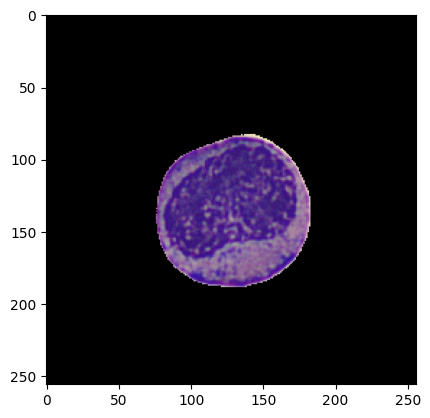

In [89]:
sample_row = clean_data.iloc[1]
combined_image = sample_row['Combined_Image']
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))


## Test and train set for classification model

In [92]:
# Load the DataFrame from the pickle file
clean_data_loaded = pd.read_pickle('/content/drive/MyDrive/unet/clean_data_with_combined_images.pkl') # to save time. next time just load the pkl cleaned file.


In [94]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [95]:
# Split into Train and Test Sets

from sklearn.model_selection import train_test_split

# Split into train and test sets
# Split into train and test sets with balanced samples according to 'Label'
train_data, test_data = train_test_split(clean_data_loaded, test_size=0.2, stratify=clean_data_loaded['Label'], random_state=42)

X_train = np.array(train_data['Combined_Image'].tolist())
y_train = train_data['Label'].values
X_test = np.array(test_data['Combined_Image'].tolist())
y_test = test_data['Label'].values

# Preprocess the images
X_train = tf.keras.applications.efficientnet.preprocess_input(X_train)
X_test = tf.keras.applications.efficientnet.preprocess_input(X_test)


In [96]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Define the EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(cell_type_mapping), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a starting learning rate of 0.001
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


16705208/16705208 [==============================] - 52s 3us/step
Epoch 1/20
274/274 [==============================] - 834s 3s/step - loss: 0.3896 - accuracy: 0.8702 - val_loss: 0.1909 - val_accuracy: 0.9453 - lr: 0.0010
Epoch 2/20
274/274 [==============================] - 728s 3s/step - loss: 0.2128 - accuracy: 0.9269 - val_loss: 0.1686 - val_accuracy: 0.9471 - lr: 0.0010
Epoch 3/20
274/274 [==============================] - 727s 3s/step - loss: 0.1696 - accuracy: 0.9414 - val_loss: 0.1702 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 4/20
274/274 [==============================] - 740s 3s/step - loss: 0.1490 - accuracy: 0.9534 - val_loss: 0.1448 - val_accuracy: 0.9548 - lr: 0.0010
Epoch 5/20
274/274 [==============================] - 542s 2s/step - loss: 0.1461 - accuracy: 0.9501 - val_loss: 0.1302 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 6/20
274/274 [==============================] - 17s 61ms/step - loss: 0.1320 - accuracy: 0.9539 - val_loss: 0.1362 - val_accuracy: 0.9599 - lr: 0.00

### save model

In [ ]:
# Save the model
import json


model.save('efficientnet_model.h5')



# Save the training history
history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)



### Classification repot

In [104]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get unique labels from y_test
unique_labels = np.unique(y_test)

# Create target names based on unique labels
target_names = [list(cell_type_mapping.keys())[list(cell_type_mapping.values()).index(label)] for label in unique_labels]

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=target_names))


86/86 [==============================] - 4s 45ms/step
              precision    recall  f1-score   support

          BA       0.95      0.97      0.96       232
         ERB       0.96      0.97      0.97       286
          LY       0.97      0.95      0.96       230
         SNE       0.98      0.97      0.98       325
          EO       0.98      0.99      0.99       608
         PMY       0.93      0.91      0.92       333
          MO       0.94      0.96      0.95       273
    PLATELET       1.00      1.00      1.00       452

    accuracy                           0.97      2739
   macro avg       0.96      0.96      0.96      2739
weighted avg       0.97      0.97      0.97      2739



### classification Confusion Matrix

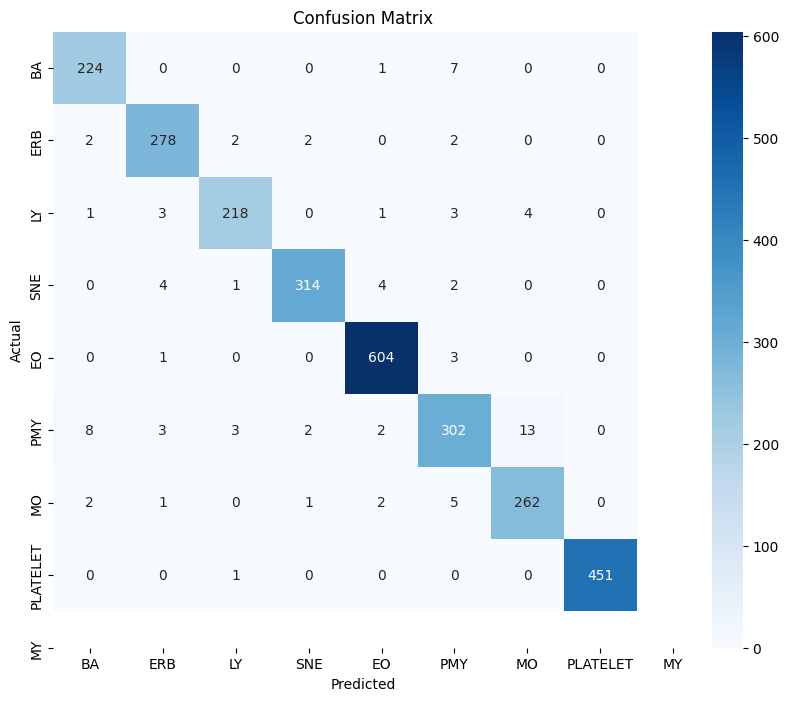

In [106]:
from sklearn.metrics import  confusion_matrix
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Save confusion matrix as a heatmap image
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
# plt.savefig('confusion_matrix.png')
plt.close()

### Plot Training History

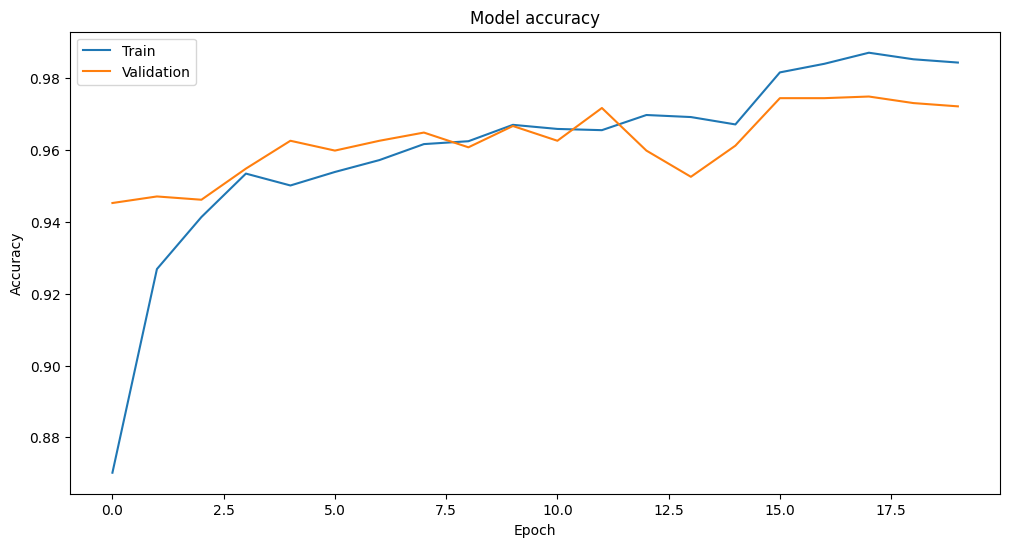

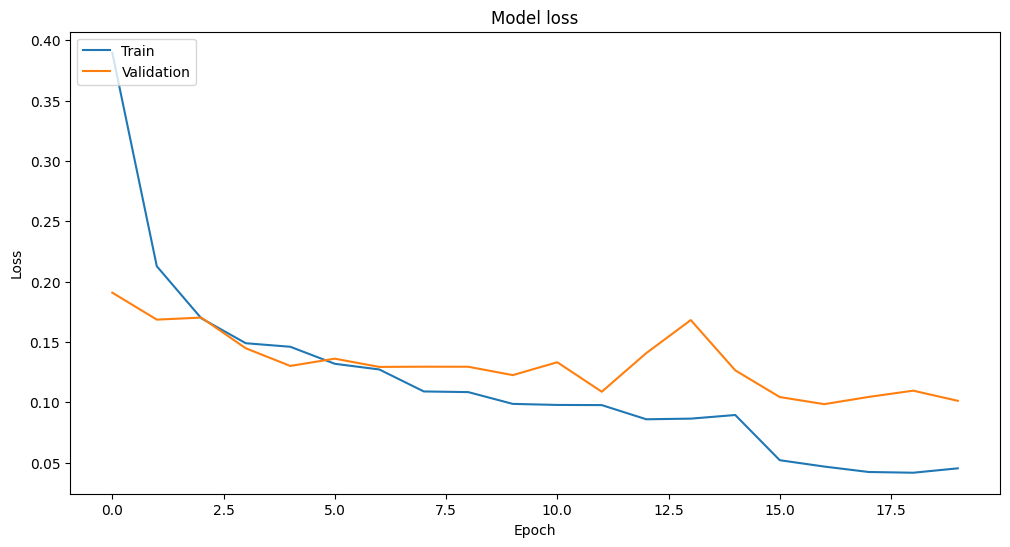

In [107]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
